In [1]:
import copy
import re
import pandas as pd
import numpy as np
from experiments import ExperimentModule
from experiments import (
    save_plots, 
    write_row, 
    write_opcounts,
    save_circuit,
    create_dir,
    get_random_state
)
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
from itertools import product
from datetime import datetime

%matplotlib inline

In [2]:
results_dir = "results/runs_shell"
run_range = list(range(1, 11))
#qubit_range = [3, 4, 5, 6, 7, 8]
qubit_range = [12, 15]

# EPS values are mapped separately
#eps_values = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
eps_values = [0.5, 0.1, 0.05, 0.01]

### Random State type

Creating pandas dataframe

Creating result dictionaries

In [51]:
state_type = "laplace"

In [52]:
#[0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
original_results_dict = {
    "num_qubits": [],
    0.5: [],
    0.1: [],
    0.05: [],
    0.01: [],
}

modified_results_dict = copy.deepcopy(original_results_dict)

for (r_dir, st_typse, num_qubits, eps) in product([results_dir], [state_type], qubit_range, eps_values):
    if not num_qubits in original_results_dict["num_qubits"]: 
        original_results_dict["num_qubits"] += [num_qubits]
        modified_results_dict["num_qubits"] += [num_qubits]

    original_results_dict[eps] += [[]]
    modified_results_dict[eps] += [[]]

    for run_idx in run_range:
        fid_loss_original = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/original_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
        data_original = fid_loss_original[-1][-1] if len(fid_loss_original.shape) > 1 else fid_loss_original[-1]
        original_results_dict[eps][-1] += [data_original.round(4)]

        fid_loss_modified = np.loadtxt(f"{results_dir}/{st_type}/run_{run_idx}/csv/modified_fidloss_{num_qubits}qb_{eps}eps.csv", delimiter=",")
        data_modified = fid_loss_modified[-1][-1] if len(fid_loss_modified.shape) > 1 else fid_loss_modified[-1]
        modified_results_dict[eps][-1]+= [data_modified.round(4)]

In [53]:
default_dict = {
    "num_qubits": qubit_range,
    0.5: [],
    0.1: [],
    0.05: [],
    0.01: [],
}
mean_original_results_dict = copy.deepcopy(default_dict)
mean_modified_results_dict = copy.deepcopy(default_dict)

stds_original_results_dict = copy.deepcopy(default_dict)
stds_modified_results_dict = copy.deepcopy(default_dict)

for eps in eps_values:
    mean_original_results_dict[eps] = np.mean(original_results_dict[eps], axis=1)
    stds_original_results_dict[eps] = np.std(original_results_dict[eps], axis=1).round(2)

    mean_modified_results_dict[eps] = np.mean(modified_results_dict[eps], axis=1)
    stds_modified_results_dict[eps] = np.std(modified_results_dict[eps], axis=1).round(2)

Original fidloss

In [54]:
df_mean_original = pd.DataFrame(mean_original_results_dict)
df_mean_original = df_mean_original.set_index("num_qubits")
display(df_mean_original)

df_stds_original = pd.DataFrame(stds_original_results_dict)
df_stds_original = df_stds_original.set_index("num_qubits")
df_stds_original

,0.5,0.1,0.05,0.01
num_qubits,,,,
12,0.99474,0.99998,0.99393,0.98003
15,0.02551,0.12431,0.07719,0.19657


,0.5,0.1,0.05,0.01
num_qubits,,,,
12,0.02,0.00,0.02,0.03
15,0.02,0.29,0.09,0.06


In [55]:
print(df_mean_original.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrr}
\toprule
 & 0.500000 & 0.100000 & 0.050000 & 0.010000 \\
num_qubits &  &  &  &  \\
\midrule
12 & 0.9947 & 1.0000 & 0.9939 & 0.9800 \\
15 & 0.0255 & 0.1243 & 0.0772 & 0.1966 \\
\bottomrule
\end{tabular}



Modified fidloss

In [56]:
df_mean_modified = pd.DataFrame(mean_modified_results_dict)
df_mean_modified = df_mean_modified.set_index("num_qubits")
display(df_mean_modified)

df_stds_modified = pd.DataFrame(stds_modified_results_dict)
df_stds_modified = df_stds_modified.set_index("num_qubits")
df_stds_modified

,0.5,0.1,0.05,0.01
num_qubits,,,,
12,1.00000,0.96634,0.02676,0.18096
15,0.30847,0.01210,0.01191,0.13427


,0.5,0.1,0.05,0.01
num_qubits,,,,
12,0.00,0.05,0.03,0.34
15,0.45,0.00,0.00,0.28


In [57]:
print(df_mean_modified.to_latex(float_format="%.4f"))

\begin{tabular}{lrrrr}
\toprule
 & 0.500000 & 0.100000 & 0.050000 & 0.010000 \\
num_qubits &  &  &  &  \\
\midrule
12 & 1.0000 & 0.9663 & 0.0268 & 0.1810 \\
15 & 0.3085 & 0.0121 & 0.0119 & 0.1343 \\
\bottomrule
\end{tabular}



Counting depth

In [58]:
depth_count_original = []
depth_count_modified = []

for qb_idx, num_qubits in enumerate(qubit_range):
    depth_count_original += [[]]
    depth_count_modified += [[]]

    for eps in eps_values:
        #circuit = load_circuit(f"results/circuits/curcuit_{num_qubits}qb_{eps}eps.pkl")
        state = get_random_state(num_qubits)

        # original
        ansatz = SanchezAnsatz(state, eps)
        to_ansatz = transpile(ansatz, basis_gates=["cx", "u"])
        depth_count_original[qb_idx] += [to_ansatz.depth()]

        # modified
        mod_ansatz = SanchezAnsatz(state, eps, build_modified=True)
        tm_ansatz = transpile(mod_ansatz, basis_gates=["cx", "u"])
        depth_count_modified[qb_idx] += [tm_ansatz.depth()]


[]

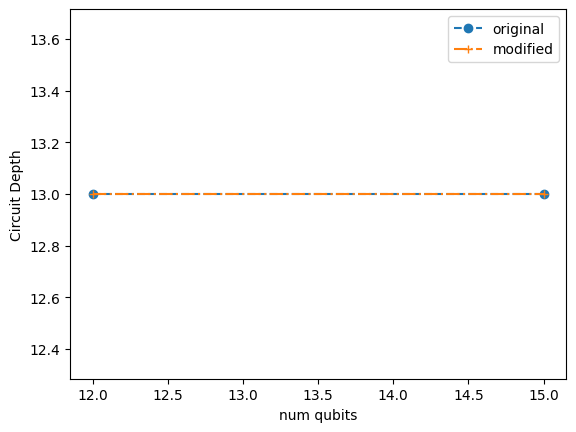

In [59]:
mean_depth_original = np.mean(depth_count_original, axis=1, dtype=np.int32)
mean_depth_modified = np.mean(depth_count_modified, axis=1, dtype=np.int32)

plt.plot(qubit_range, mean_depth_original, "--", marker="o", label='original')
plt.plot(qubit_range, mean_depth_modified, "-.", marker="+", label="modified")
plt.xlabel("num qubits")
plt.ylabel("Circuit Depth")
plt.legend(loc="best")
plt.plot()
#plt.savefig(f"{results_dir}/mean_circuit_depth.pdf")